In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import platform

In [2]:
if platform.system() == 'Windows':
    pathlib.PosixPath = pathlib.WindowsPath

In [3]:
sys.path.append(os.path.abspath(".."))

In [4]:
from src.preprocessing.catalog_reader import read_catalog
from src.preprocessing.param_scheme_reader import get_dist_from_scheme
from src.sst.storm_sampler import sample_storms
from src.utils_spatial.spatial_stats import get_sp_stats
from src.stats.distribution_helpers import truncnorm_params, fit_rotated_normal_to_polygon
from src.stats.distributions import TruncatedGeneralizedNormal, TruncatedDistribution, MixtureDistribution, RotatedNormal
from src.sst.sst_simulation import simulate_sst
from src.evaluation.sampling_eval import print_sim_stats
from src.evaluation.plotting import plot_sample_centers, plot_xy_vs_depth, plot_xy_vs_depth_2d, plot_freq_curve

In [5]:
# Select Watershed
name_watershed = ['Duwamish', 'Kanawha', 'Trinity'][2]
folder_watershed = rf'../data/1_interim/{name_watershed}'
os.chdir(folder_watershed)
cwd = pathlib.Path.cwd()

In [6]:
# Read watershed, domain, and storm catalogue
sp_watershed, sp_domain, df_storms = read_catalog(cwd)
df_storms = df_storms.assign(path = lambda _: _.path.apply(lambda _x: _x.absolute()))


Reprojecting polygon from EPSG:4326 to EPSG:5070 for rioxarray...
Reprojecting polygon from EPSG:4326 to EPSG:5070 for rioxarray...


In [7]:
# Get polygon info (bounds, centroids, ranges)
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)

In [8]:
#Set number of simulations
n_sim_mc = 1_000
n_sim_is = 100_0

In [17]:
df_depths_mc_0, df_prob_mc_0, df_aep_mc_0 = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x=None, dist_y=None, num_simulations=n_sim_mc)
df_depths_mc_0.to_pickle(cwd/'pickle'/f'df_depths_mc_0.pkl')
df_prob_mc_0.to_pickle(cwd/'pickle'/f'df_prob_mc_0.pkl')
df_aep_mc_0.to_pickle(cwd/'pickle'/f'df_aep_mc_0.pkl')

Computing depths:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing depths: 100%|██████████| 1000/1000 [00:04<00:00, 235.53it/s]


In [18]:
# Run Monte Carlo for comparison
df_depths_mc, df_prob_mc, df_aep_mc = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x=None, dist_y=None, num_simulations=n_sim_is)
df_depths_mc.to_pickle(cwd/'pickle'/f'df_depths_mc_n_{n_sim_is}.pkl')
df_prob_mc.to_pickle(cwd/'pickle'/f'df_prob_mc_n_{n_sim_is}.pkl')
df_aep_mc.to_pickle(cwd/'pickle'/f'df_aep_mc_n_{n_sim_is}.pkl')

Computing depths:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing depths: 100%|██████████| 1000/1000 [00:01<00:00, 670.16it/s]


In [19]:
#region Set Importance Sampling Parameters
df_dist_params = pd.DataFrame(dict(
    dist = ['Truncated Normal + Uniform'],
    acronym = ['tnXu'],
    param_1_name = ['std'],
    param_1 = ['1'], # 1 for Duwamish, 0.5 for Kanahwa, 0.75 for Trinity
    param_2_name = ['w1'],
    param_2 = ['0.1'],
))

In [20]:
#region Update Importance Sampling Distribution Parameters
df_dist_params = \
(df_dist_params
    .assign(_p1 = lambda _: _.param_1.astype(str).str.replace(r'\.0$', '', regex=True))
    .assign(_p2 = lambda _: _.param_2.astype(str).str.replace(r'\.0$', '', regex=True))
    .assign(
        name_file = lambda _: _.acronym + '_' + _.param_1_name + '_' + _._p1 +
        np.where(_.param_2_name == '', '', '_' + _.param_2_name + '_' + _._p2)
    )
    .drop(columns=['_p1', '_p2'])
)
row_dist_params = df_dist_params.iloc[0]


In [21]:
# Get distribution
dist_x, dist_y = get_dist_from_scheme(row_dist_params, v_watershed_stats, v_domain_stats) 

Running for mult_std = 1.0, w1 = 0.1


/workspaces/Importance-Sampling-for-SST/src/evaluation/plotting.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/workspaces/Importance-Sampling-for-SST/src/evaluation/plotting.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWa

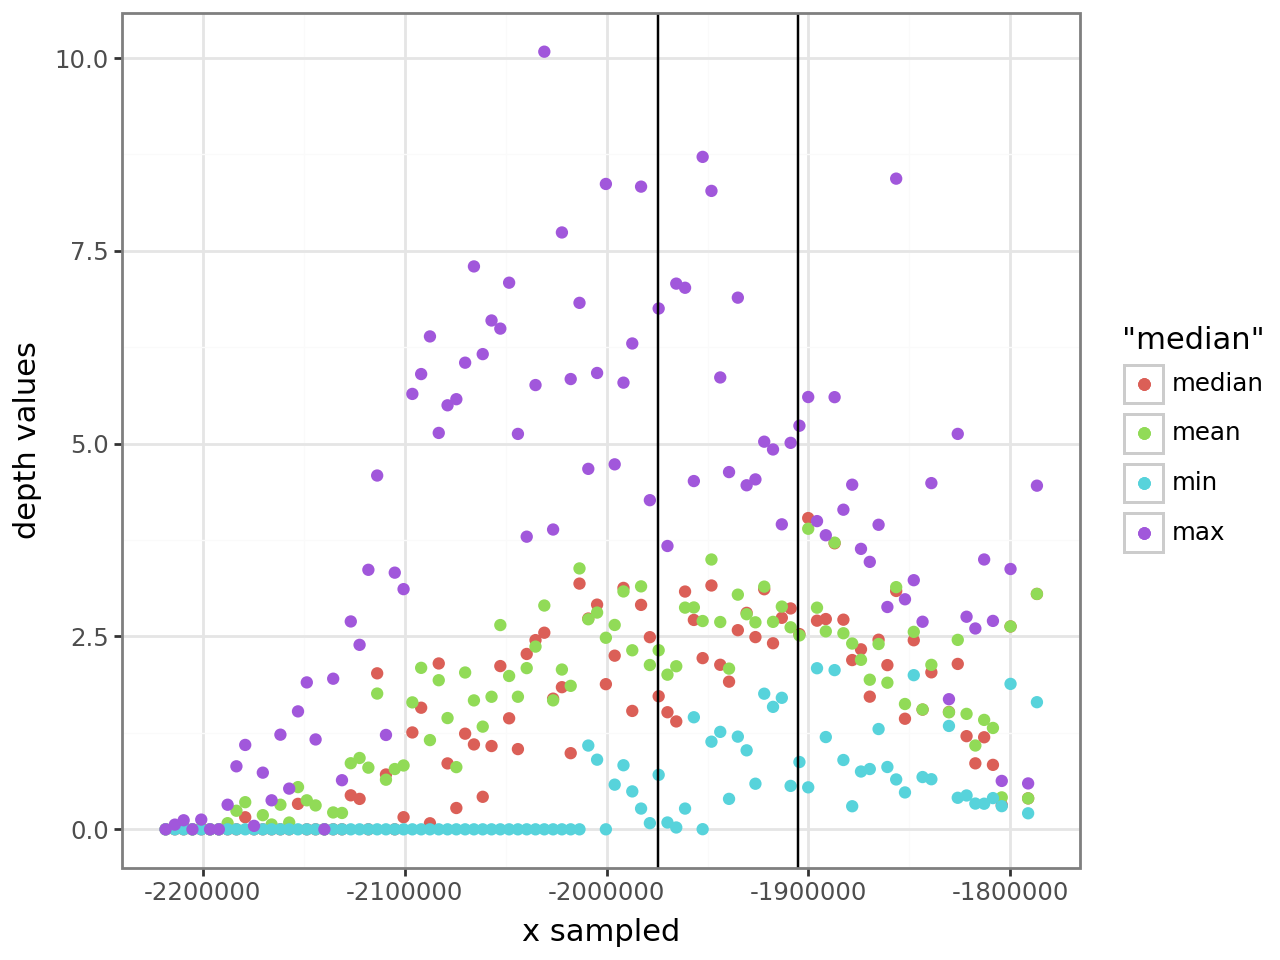

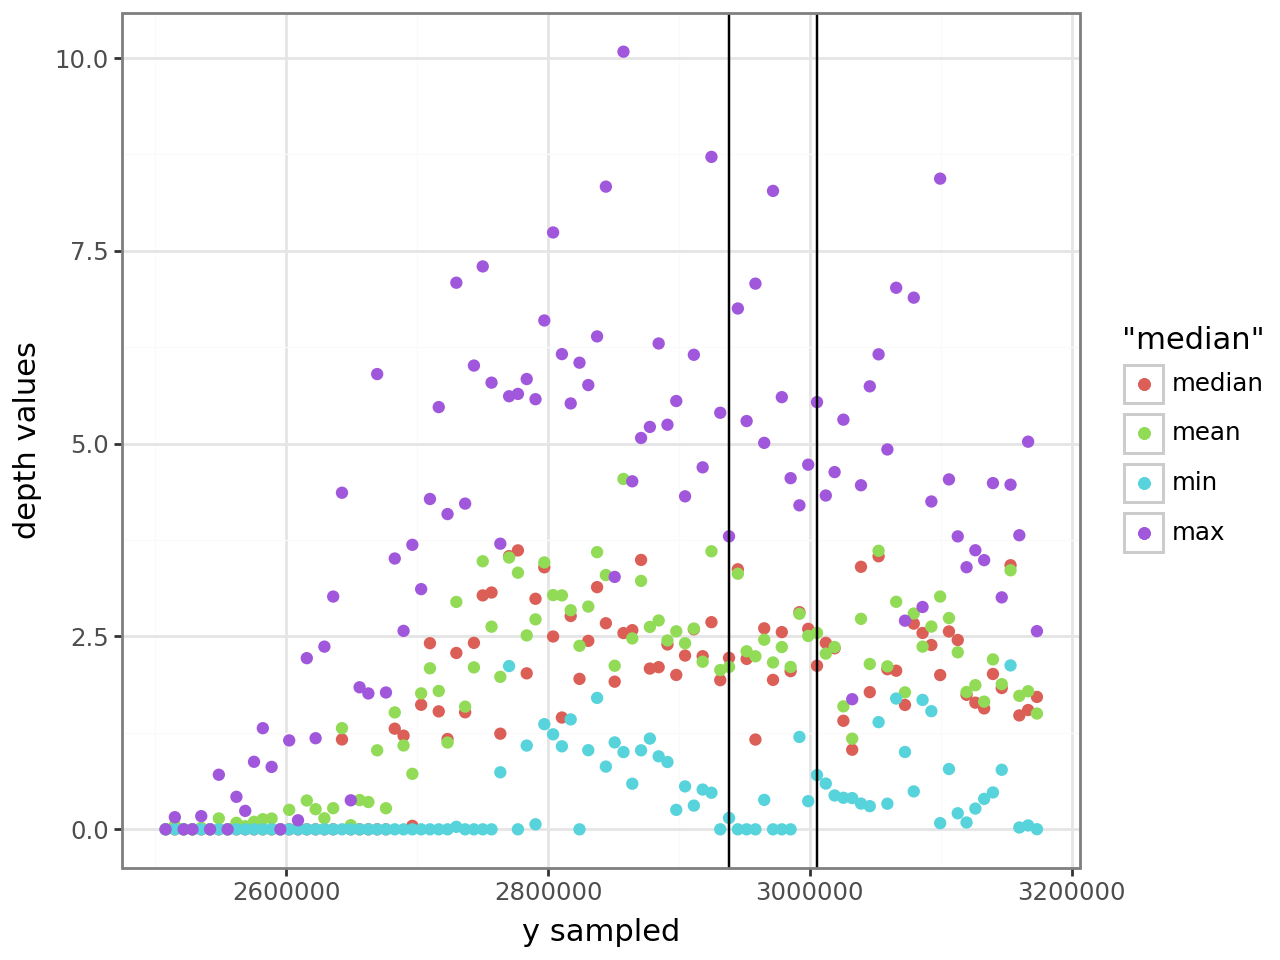

In [19]:
#region Generate Samples and Evaluate
# Plot depth vs coordinates (for full MC)
g_x, g_y = plot_xy_vs_depth(df_depths_mc_0, v_watershed_stats=v_watershed_stats)
g_x.show()
g_y.show()
# g_x.save(cwd/'plots'/f'Check x vs depth for primary Monte Carlo.png', width=10, height=7)
# g_y.save(cwd/'plots'/f'Check y vs depth for primary Monte Carlo.png', width=10, height=7)


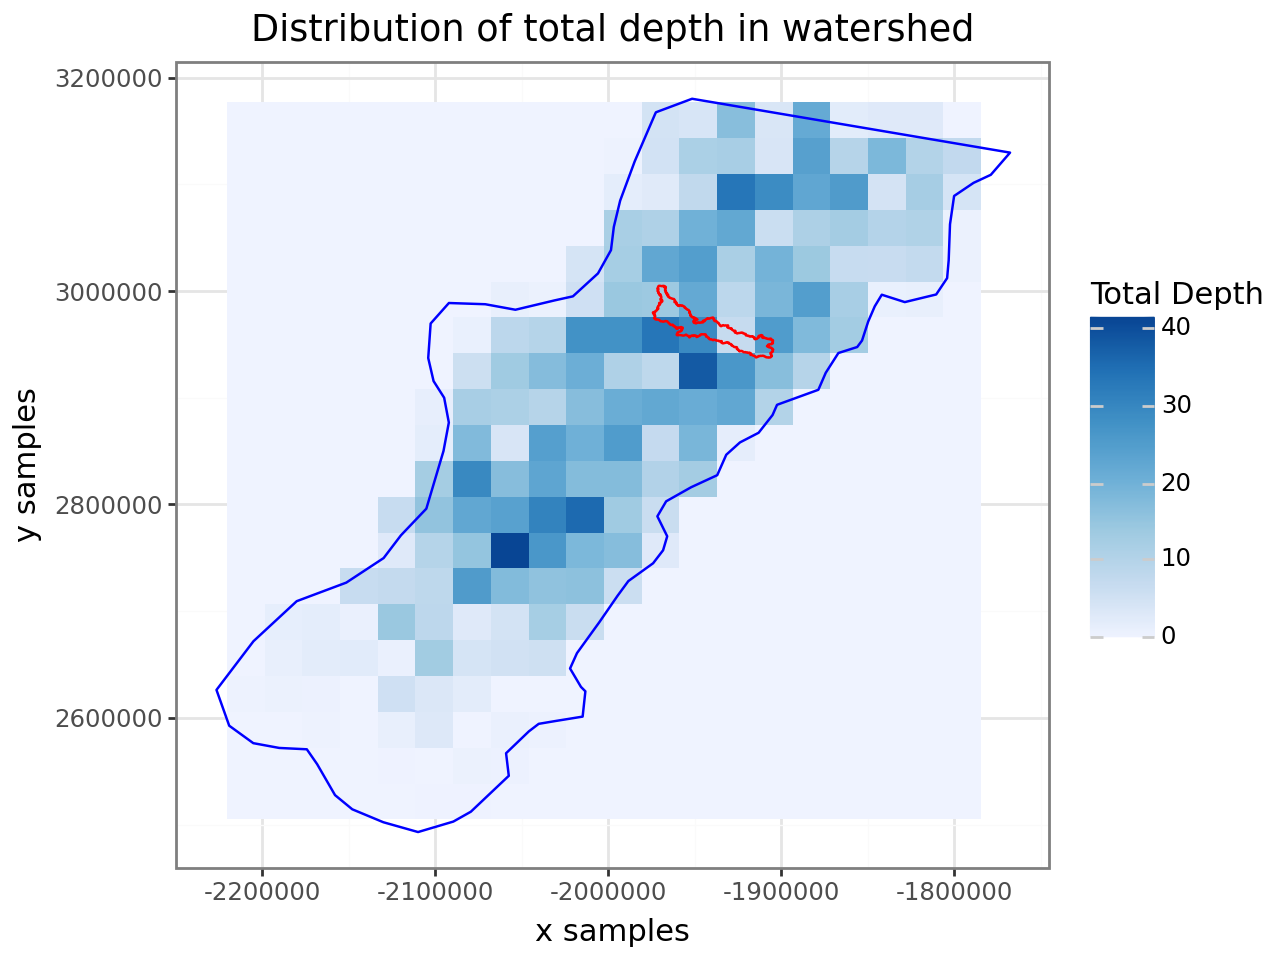

In [20]:

# Plot depth vs coordinates 2D (for full MC)
g_xy = plot_xy_vs_depth_2d(df_depths_mc_0, sp_watershed, sp_domain)
g_xy.show()
# g_xy.save(cwd/'plots'/f'Check xy vs depth for primary Monte Carlo.png', width=10, height=7)


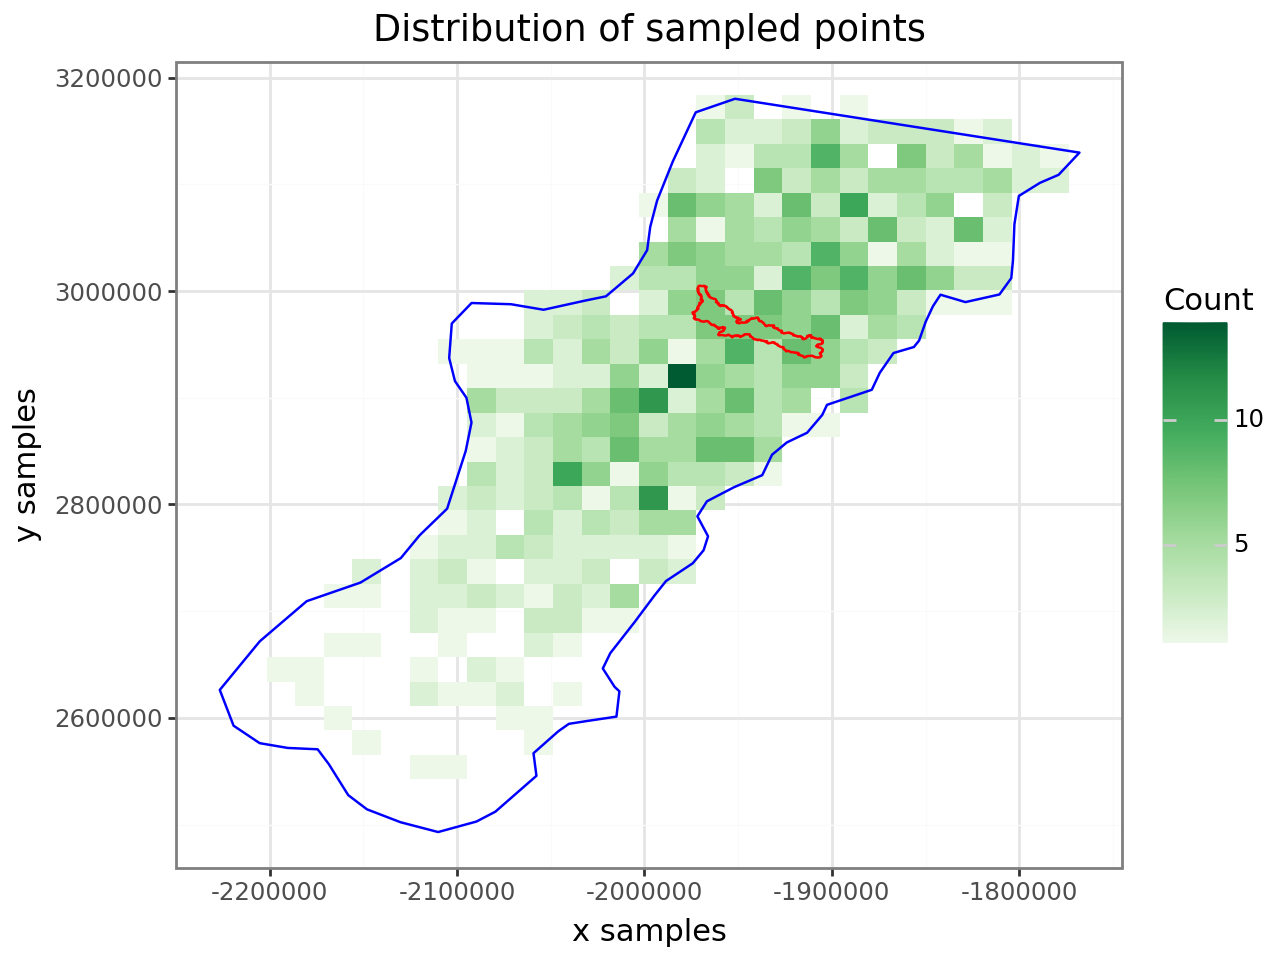

In [22]:

# Distribution of sampled points
# df_storm_sample_is = sample_storms(df_storms, sp_domain, dist_x, dist_y, num_simulations=n_sim_is)
_param_dist_xy = fit_rotated_normal_to_polygon(sp_domain.explode().geometry.iloc[0], coverage_factor=0.8)
row = pd.Series(dict(name_file = 'RN_cf_08'))
dist_xy = RotatedNormal(mean=[v_watershed_stats.x, v_watershed_stats.y], stds=_param_dist_xy.get('stds'), angle_degrees=_param_dist_xy.get('angle_degrees'))
df_storm_sample_is = sample_storms(df_storms, sp_domain, dist_xy = dist_xy, num_simulations=n_sim_is)

g = plot_sample_centers(df_storm_sample_is, sp_watershed, sp_domain, v_domain_stats)
g.show()
#g.save(cwd/'plots'/f'XY n_{n_sim_is} {row.name_file}.png', width=10, height=7)


In [23]:

#endregion -----------------------------------------------------------------------------------------
#region Run Simulations - Importance Sampling

# Run Importance Sampling
df_depths_is, df_prob_is, df_aep_is = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x, dist_y, num_simulations=n_sim_is)
df_depths_is.to_pickle(cwd/'pickle'/f'df_depths_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_prob_is.to_pickle(cwd/'pickle'/f'df_prob_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_aep_is.to_pickle(cwd/'pickle'/f'df_aep_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')

Computing depths: 100%|██████████| 1000/1000 [00:03<00:00, 282.02it/s]


In [24]:

#region Read Ground Truth
df_depths_mc_0: pd.DataFrame = pd.read_pickle(cwd/'pickle'/'df_depths_mc_0.pkl')
df_prob_mc_0: pd.DataFrame = pd.read_pickle(cwd/'pickle'/'df_prob_mc_0.pkl')
df_aep_mc_0: pd.DataFrame = pd.read_pickle(cwd/'pickle'/'df_aep_mc_0.pkl')

#endregion -----------------------------------------------------------------------------------------



In [25]:
#region Read Monte Carlo for Comparison
df_depths_mc: pd.DataFrame = pd.read_pickle(cwd/'pickle'/f'df_depths_mc_n_{n_sim_is}.pkl')
df_prob_mc: pd.DataFrame = pd.read_pickle(cwd/'pickle'/f'df_prob_mc_n_{n_sim_is}.pkl')
df_aep_mc: pd.DataFrame = pd.read_pickle(cwd/'pickle'/f'df_aep_mc_n_{n_sim_is}.pkl')


In [26]:

#region Read Importance Sampling
df_depths_is = pd.read_pickle(cwd/'pickle'/f'df_depths_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_prob_is = pd.read_pickle(cwd/'pickle'/f'df_prob_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_aep_is = pd.read_pickle(cwd/'pickle'/f'df_aep_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')


In [27]:

#region Evaluation
#Print some stats about the simulations
print_sim_stats(df_depths_mc_0)
print_sim_stats(df_depths_mc)
print_sim_stats(df_depths_is)


Intersected: 898 out of 1000 (89.80%)
Total Weights: Total  1.00, Intersected: 0.90
Weight sum/N simulations: 1.0
ESS: 1000
Depth Estimate (self-normalized): 1.96 ± 0.05
Depth Estimate (non-normalized): 1.96 ± 0.05

Intersected: 911 out of 1000 (91.10%)
Total Weights: Total  1.00, Intersected: 0.91
Weight sum/N simulations: 1.0
ESS: 1000
Depth Estimate (self-normalized): 1.84 ± 0.05
Depth Estimate (non-normalized): 1.84 ± 0.05

Intersected: 999 out of 1000 (99.90%)
Total Weights: Total  1.00, Intersected: 0.94
Weight sum/N simulations: 156382591620.68607
ESS: 58
Depth Estimate (self-normalized): 2.36 ± 0.23
Depth Estimate (non-normalized): 369816636756.44 ± 62963533073.85



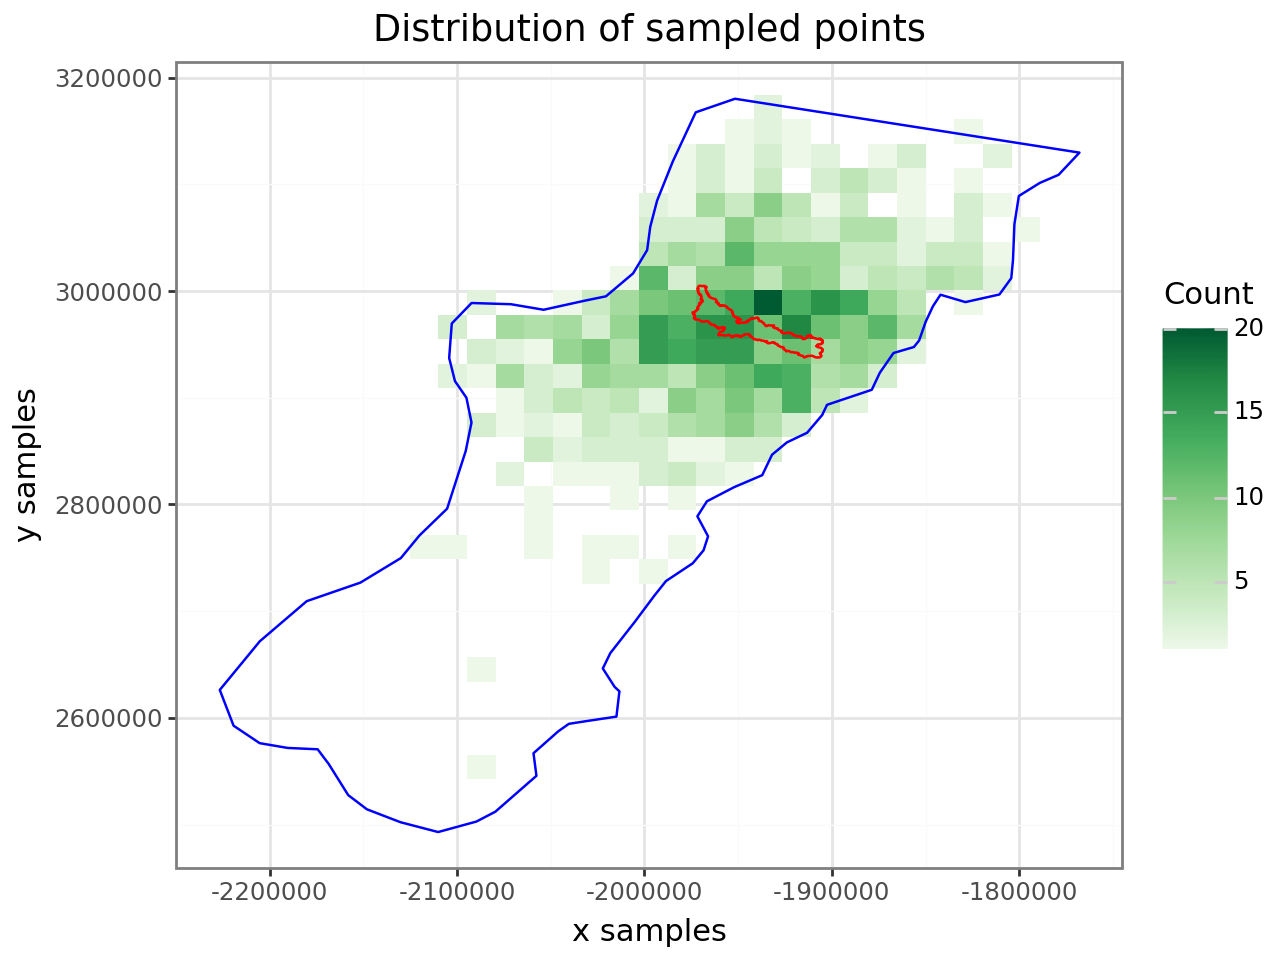

In [28]:
# Distribution of sampled points
g = plot_sample_centers(df_depths_is, sp_watershed, sp_domain, v_domain_stats)
g.show()
# g.save(cwd/'plots'/f'XY n_{n_sim_is} {row.name_file}.png', width=10, height=7)


338
287
348


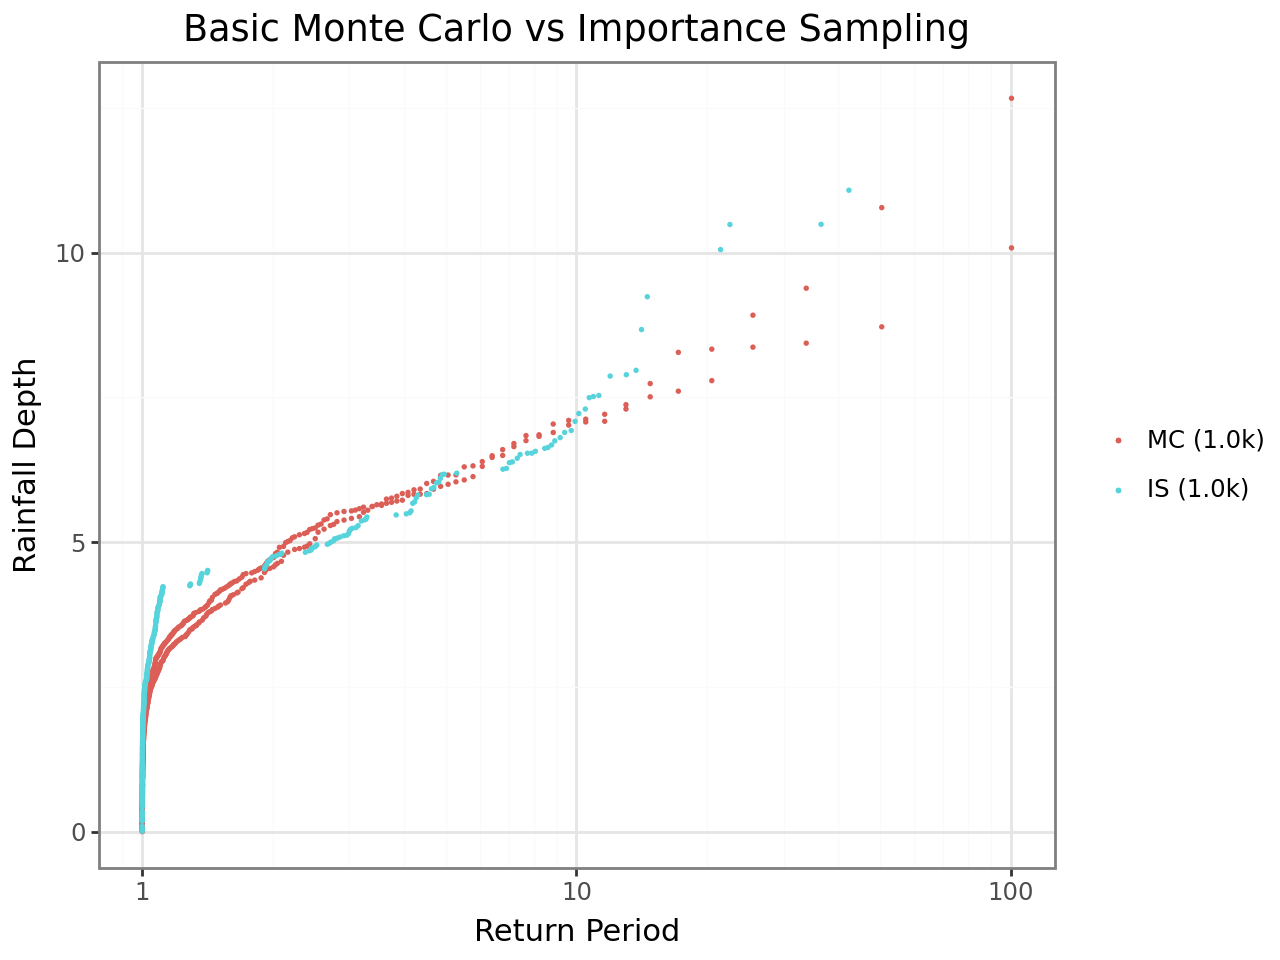

In [29]:

# Plot frequency curves
g = plot_freq_curve([df_prob_mc_0, df_prob_mc, df_prob_is], [f'MC ({n_sim_mc/1000}k)', f'MC ({n_sim_is/1000}k)', f'IS ({n_sim_is/1000}k)'])
g.show()
# g.save(cwd/'plots'/f'Freq n_{n_sim_is} {row.name_file}.png', width=10, height=7)


In [ ]:
#region Read Storn Info
df_storm_stats = pd.read_pickle(cwd/'pickle'/'df_storm_stats.pkl')

minx      -1.974568e+06
miny       2.938089e+06
maxx      -1.905108e+06
maxy       3.005395e+06
x         -1.942311e+06
y          2.965859e+06
range_x    6.946011e+04
range_y    6.730658e+04
Name: 0, dtype: float64

In [9]:
import numpy as np
import pandas as pd
from shapely.geometry import Point
from scipy.stats import multivariate_normal, laplace
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
area_watershed = sp_watershed.geometry.area.sum()
area_domain = sp_domain.geometry.area.sum()
ratio = area_watershed / area_domain
ratio

np.float64(0.05043355883184495)

In [11]:
def sample_storm_centers(watershed_gpd, domain_gpd, num_samples=10000):
    from shapely.geometry import Point
    from shapely.geometry import box
    from scipy.stats import multivariate_normal, laplace
    import numpy as np
    import pandas as pd

    # Sampling ratio
    ratio = 0.1
    domain_geom = domain_gpd.geometry.unary_union
    area_domain = domain_geom.area
    area_watershed = watershed_gpd.geometry.area.sum()

    # Number of points from each proposal
    n_normal_target = int(num_samples * ratio)
    n_laplace_target = num_samples - n_normal_target

    # Watershed centroid = center of both distributions
    centroid = watershed_gpd.geometry.unary_union.centroid
    mean = np.array([centroid.x, centroid.y])

    # SDs: Normal is wide (full domain), Laplace is tighter (watershed)
    domain_bounds = domain_gpd.total_bounds
    watershed_bounds = watershed_gpd.total_bounds

    sd_normal = [(domain_bounds[2] - domain_bounds[0]),
                 (domain_bounds[3] - domain_bounds[1])]
    sd_laplace = [(watershed_bounds[2] - watershed_bounds[0]) / 4,
                  (watershed_bounds[3] - watershed_bounds[1]) / 4]

    # Iterative sampling
    samples = []
    weights = []
    total_accepted = 0
    normal_count = 0
    laplace_count = 0

    while total_accepted < num_samples:
        # Oversample
        n_batch = 1000

        # Normal batch
        n_norm_batch = min(n_batch, n_normal_target - normal_count)
        normal_samples = np.random.multivariate_normal(mean, np.diag(sd_normal)**2, size=n_norm_batch)

        # Laplace batch
        n_lap_batch = min(n_batch, n_laplace_target - laplace_count)
        laplace_x = laplace.rvs(loc=mean[0], scale=sd_laplace[0], size=n_lap_batch)
        laplace_y = laplace.rvs(loc=mean[1], scale=sd_laplace[1], size=n_lap_batch)
        laplace_samples = np.column_stack((laplace_x, laplace_y))

        # Combine and tag
        new_samples = []
        new_weights = []
        for s in normal_samples:
            pt = Point(s[0], s[1])
            if domain_geom.contains(pt):
                f_normal = multivariate_normal.pdf(s, mean=mean, cov=np.diag(sd_normal)**2)
                f_laplace = laplace.pdf(s[0], loc=mean[0], scale=sd_laplace[0]) * \
                            laplace.pdf(s[1], loc=mean[1], scale=sd_laplace[1])
                q = ratio * f_normal + (1 - ratio) * f_laplace
                w = (1 / area_domain) / q
                new_samples.append(s)
                new_weights.append(w)
                normal_count += 1
                if len(new_samples) + len(samples) >= num_samples:
                    break

        for s in laplace_samples:
            pt = Point(s[0], s[1])
            if domain_geom.contains(pt):
                f_normal = multivariate_normal.pdf(s, mean=mean, cov=np.diag(sd_normal)**2)
                f_laplace = laplace.pdf(s[0], loc=mean[0], scale=sd_laplace[0]) * \
                            laplace.pdf(s[1], loc=mean[1], scale=sd_laplace[1])
                q = ratio * f_normal + (1 - ratio) * f_laplace
                w = (1 / area_domain) / q
                new_samples.append(s)
                new_weights.append(w)
                laplace_count += 1
                if len(new_samples) + len(samples) >= num_samples:
                    break

        samples.extend(new_samples)
        weights.extend(new_weights)
        total_accepted = len(samples)

    # Normalize weights
    weights = np.array(weights)
    weights /= weights.sum()
    samples = np.array(samples)

    return pd.DataFrame({
        "x": samples[:, 0],
        "y": samples[:, 1],
        "weight": weights
    })


In [22]:
df_storms = sample_storm_centers(sp_watershed, sp_domain, num_samples=10000)

/tmp/ipykernel_31716/968810276.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
/tmp/ipykernel_31716/968810276.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


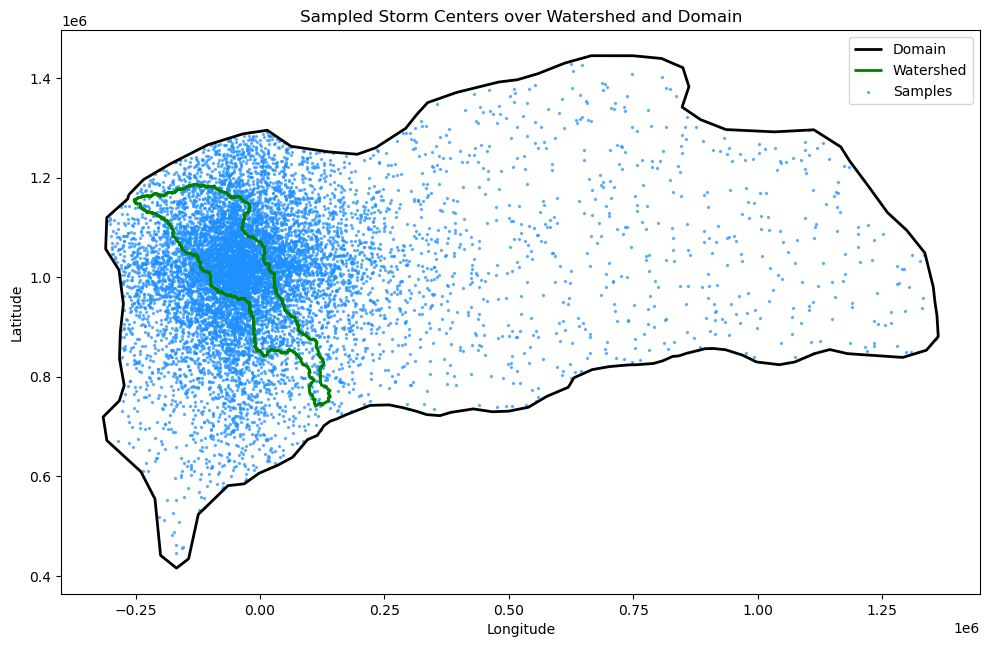

In [13]:
# Convert samples to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_samples, geometry=gpd.points_from_xy(df_samples.x, df_samples.y), crs=sp_domain.crs)

# Plot everything together
fig, ax = plt.subplots(figsize=(10, 10))

# Plot domain and watershed boundaries
sp_domain.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label="Domain")
sp_watershed.boundary.plot(ax=ax, edgecolor='green', linewidth=2, label="Watershed")

# Plot storm center samples
gdf_samples.plot(ax=ax, color='dodgerblue', markersize=2, alpha=0.6, label="Samples")

ax.set_title("Sampled Storm Centers over Watershed and Domain")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

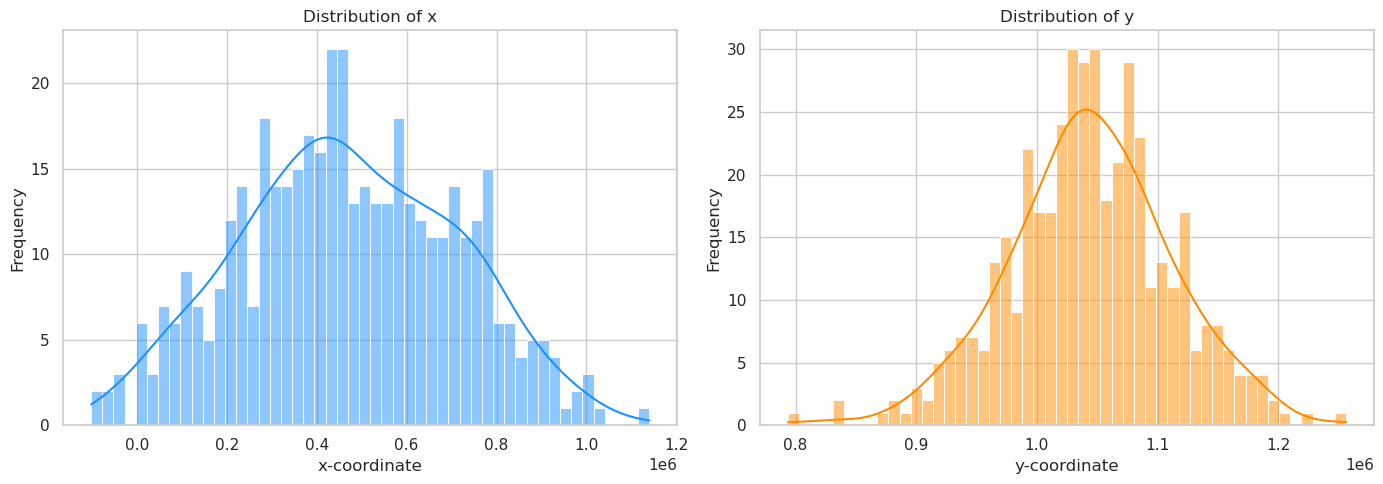

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure seaborn style is set
sns.set(style="whitegrid")

# Plot x and y distributions side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# X distribution
sns.histplot(df_storms['x'], kde=True, ax=ax[0], color="dodgerblue", bins=50)
ax[0].set_title("Distribution of x")
ax[0].set_xlabel("x-coordinate")
ax[0].set_ylabel("Frequency")

# Y distribution
sns.histplot(df_storms['y'], kde=True, ax=ax[1], color="darkorange", bins=50)
ax[1].set_title("Distribution of y")
ax[1].set_xlabel("y-coordinate")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [23]:
df_depths_is, df_prob_is, df_aep_is = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x, dist_y, num_simulations=n_sim_is)

KeyError: "['path'] not in index"